## Preliminaries

Import statements. We need dices to talk to the database, pandas to make tables, pyplot for figures, and some Jupyter bits and bobs.

In [1]:
from dicesapi import DicesAPI
from dicesapi.jupyter import NotebookPBar
from dicesapi.text import CtsAPI
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import re
import os
import pickle
%matplotlib inline

Initialize connection to the DICES database

In [2]:
api = DicesAPI(
    logfile = 'lucan.log',
    progress_class = NotebookPBar,
)
cts = CtsAPI()

## Index locations in Lucan

Create a lookup table to find relative position in the text. We'll have to download the entire poem from Perseus and check the line numbers for each book.

In [3]:
urn_lucan = 'urn:cts:latinLit:phi0917.phi001.perseus-lat2'
pickle_lucan = 'lucan.pickle'

Download all the canonical loci in Lucan from Perseus in a big table

In [4]:
l_table_lucan = pd.DataFrame(dict(locus=api.resolver.getReffs(urn_lucan, level=2)))

Organize the data a little:

In [5]:
# put book and line numbers into separate cols
l_table_lucan[['book', 'line']] = l_table_lucan['locus'].str.split('.').apply(pd.Series)

# set create an index so we can look up loci
l_table_lucan = l_table_lucan.set_index('locus')

In [6]:
l_table_lucan

,book,line
locus,,
1.1,1,1
1.2,1,2
1.3,1,3
1.4,1,4
1.5,1,5
...,...,...
10.542,10,542
10.543,10,543
10.544,10,544


## Download the Lucan speeches from DICES

If pickled version exists, use that.

In [7]:
if os.path.exists(pickle_lucan):
    with open(pickle_lucan, 'rb') as f:
        speeches_lucan = pickle.load(f)
else:
    speeches_lucan = api.getSpeeches(work_id=6, progress=True)

Download the text of the speeches from Perseus.

In [8]:
pbar = NotebookPBar(max=len(speeches_lucan))

for s in speeches_lucan:
    if not hasattr(s, 'passage'):
        s.passage = cts.getPassage(s)
    pbar.update()

Parse the speeches with CLTK

In [9]:
pbar = NotebookPBar(max=len(speeches_lucan))

for s in speeches_lucan:
    if s.passage.cltk is None:
        s.passage.runCltkPipeline()
    pbar.update()

#### Pickle processed speeches to save time later

In [10]:
with open(pickle_lucan, 'wb') as f:
    pickle.dump(speeches_lucan, f)

## Convert the list of speeches into a useful table

Helper functions to classify addressee constellations

In [11]:
def get_addr_gender(s):
    '''simplify gender strings to one of four categories:
        - male
        - female
        - mixed
        - undefined
    '''
    
    genders = set([inst.gender for inst in s.addr])
    
    if 'female' in genders and 'male' in genders:
        gender = 'mixed'
    elif 'female' in genders:
        gender = 'female'
    elif 'male' in genders:
        gender = 'male'
    else:
        gender = 'undefined'

    return gender

def get_addr_being(s):
    '''simplify being strings to one of four categories:
        - mortal
        - divine
        - mixed
        - other
    '''
    
    beings = set([inst.being for inst in s.addr])
    
    if 'mortal' in beings and 'divine' in beings:
        being = 'mixed'
    elif 'mortal' in beings:
        being = 'mortal'
    elif 'divine' in beings:
        being = 'divine'
    else:
        being = 'other'

    return being

In [12]:
def speech_row(s):
    '''turn a speech into a row in a data table'''
    
    return dict(
        id = s.id,
        loc_fi = s.l_fi,
        loc_la = s.l_la,
        book = int(s.l_fi.split('.')[0]),
        l_fi = int(s.l_fi.split('.')[1]),
        l_la = int(s.l_la.split('.')[1]),
        spkr = ', '.join(inst.name for inst in s.spkr),
        addr = ', '.join(inst.name for inst in s.addr),
        text = s.passage.text,
        n_words = len([w for w in s.passage.cltk if w.pos.name != 'punctuation']),
        spkr_is_female = 'female' in [inst.gender for inst in s.spkr],
        spkr_is_mortal = 'mortal' in [inst.being for inst in s.spkr],
        addr_gender = get_addr_gender(s),        
        addr_being = get_addr_being(s),
    )

In [13]:
# create a big table
s_table_lucan = pd.DataFrame(speech_row(s) for s in speeches_lucan)

# cross-reference the loci table to get serial positions w/in work of start/end
s_table_lucan['pos_fi'] = s_table_lucan['loc_fi'].apply(l_table_lucan.index.get_loc)
s_table_lucan['pos_la'] = s_table_lucan['loc_la'].apply(l_table_lucan.index.get_loc)
s_table_lucan['n_lines'] = s_table_lucan['pos_la'] - s_table_lucan['pos_fi'] + 1

In [14]:
s_table_lucan

,id,loc_fi,loc_la,book,l_fi,l_la,spkr,addr,text,n_words,spkr_is_female,spkr_is_mortal,addr_gender,addr_being,pos_fi,pos_la,n_lines
0,2376,1.190,1.192,1,190,192,Roma,"Gaius Julius Caesar, soldiers",Et gemitu permixta loqui: Quo tenditis ultra? ...,23,True,False,male,mortal,189,191,3
1,2377,1.195,1.203,1,195,203,Gaius Julius Caesar,Roma,Mox ait: O magnae qui moenia prospicis urbis T...,62,False,True,female,other,194,202,9
2,2378,1.248,1.257,1,248,257,people of Arminium,"Fortuna, people of Arminium","O male vicinis haec moenia condita Gallis, O t...",66,False,True,female,mixed,247,256,10
3,2379,1.273,1.291,1,273,291,Gaius Scribonius Curio,Gaius Julius Caesar,"Conspexit: Dum voce tuae potuere iuvari, Caesa...",125,False,True,male,mortal,272,290,19
4,2380,1.299,1.351,1,299,351,Gaius Julius Caesar,soldiers,"Bellorum o socii, qui, mille pericula Martis M...",343,False,True,male,mortal,298,350,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2494,9.1064,9.1104,9,1064,1104,Gaius Julius Caesar,satelles,"Aufer ab adspectu nostro funesta, satelles, Re...",267,False,True,male,mortal,7468,7508,41
119,2495,10.85,10.103,10,85,103,Cleopatra VII Philopator,Gaius Julius Caesar,"Et sic orsa loqui: Si qua est, o maxime Caesar...",126,True,True,male,mortal,7597,7615,19
120,2496,10.176,10.192,10,176,192,Gaius Julius Caesar,Acoreus,"O sacris devote senex, quodque arguit aetas, N...",111,False,True,male,mortal,7688,7704,17
121,2497,10.194,10.331,10,194,331,Acoreus,Gaius Julius Caesar,"Fas mihi, magnorum, Caesar, secreta parentum P...",897,False,True,male,mortal,7706,7843,138


In [15]:
s_table_lucan.to_csv('lucan_export.csv')

## Plots

In [16]:
mpl.style.use('seaborn-colorblind')
cmap = mpl.cm.get_cmap('tab20b')

### Relative position of each speech

Create a plot background showing line number and book divisions

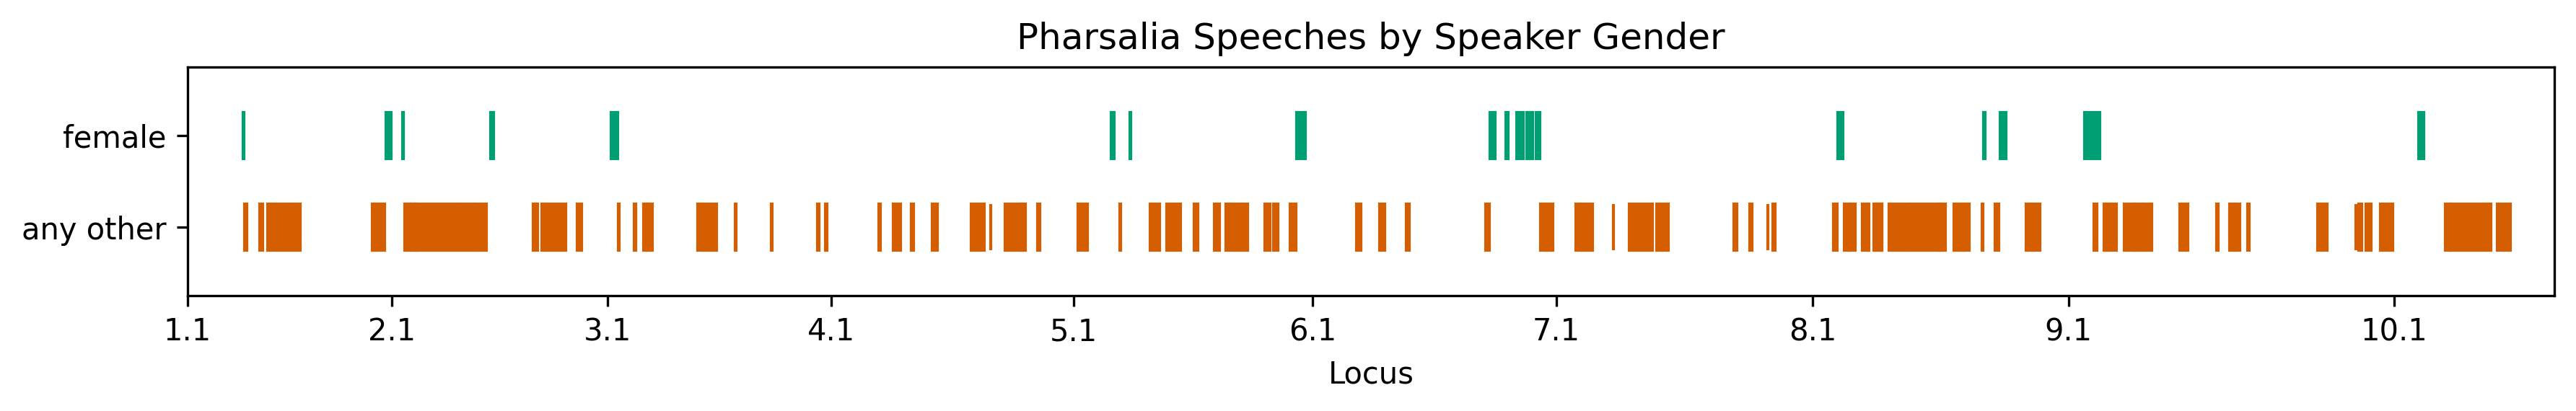

In [17]:
# create an empty plot
fig, ax = plt.subplots(figsize=(12, 2), tight_layout=True, dpi=300)
ax.set_xlim(0, len(l_table_lucan))
ax.set_ylim(0, 1)

# vertical locations of the two categories
v_hi = 0.7
v_lo = 0.3

# titles
ax.set_title('Pharsalia Speeches by Speaker Gender')
ax.set_xlabel('Locus')

# mark book divisions
is_div = l_table_lucan['line']=='1'
ax.set_xticks(np.flatnonzero(is_div), labels=l_table_lucan.index[is_div])
ax.set_yticks([v_lo, v_hi], labels=['any other', 'female'])

# draw speeches as horizontal bars
for row in s_table_lucan.itertuples():
    if row.spkr_is_female:
        v = v_hi
        c = 'C1'
    else:
        v = v_lo
        c = 'C2'
    ax.axvspan(row.pos_fi, row.pos_la, v-0.1, v+0.1, color=c)
    
# save as image
fig.savefig('fig/lucan_speech_loc_by_gender.jpg')

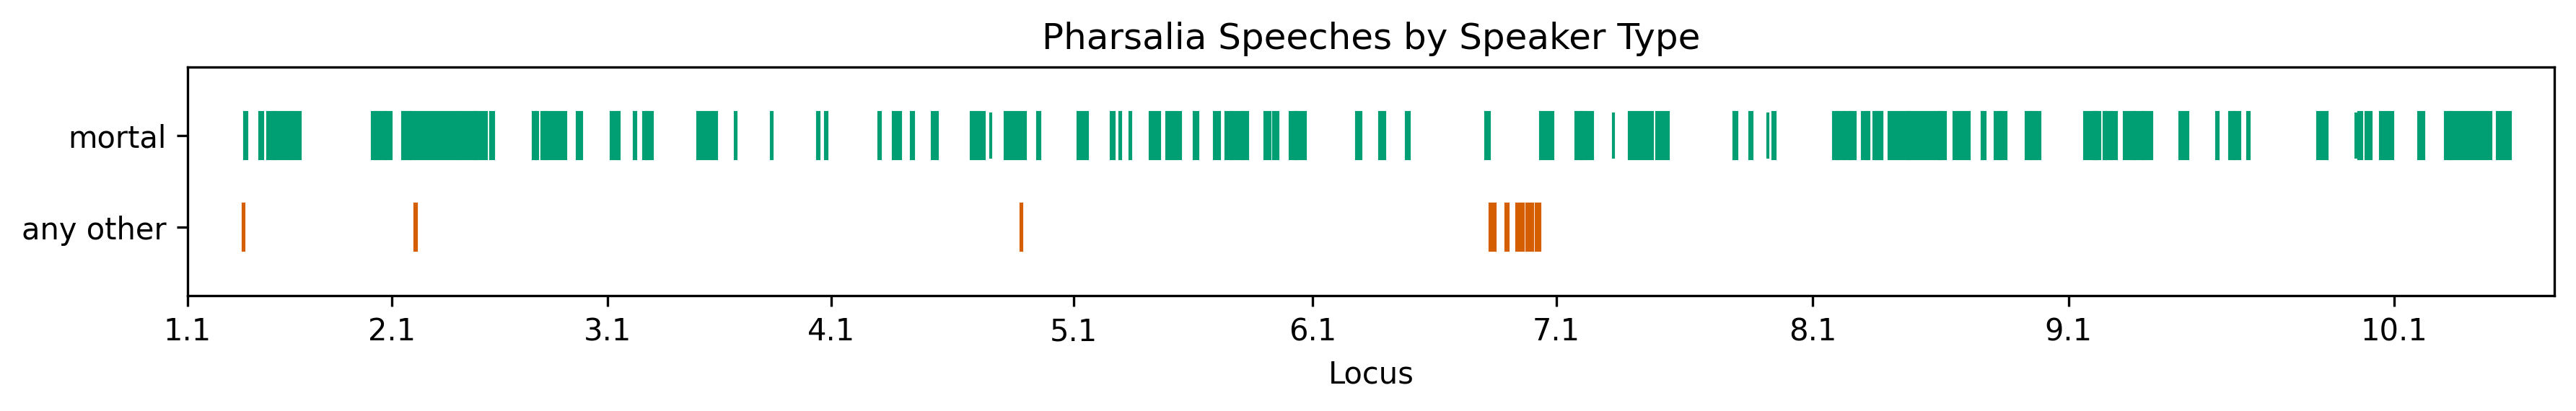

In [18]:
# create an empty plot
fig, ax = plt.subplots(figsize=(12, 2), tight_layout=True, dpi=300)
ax.set_xlim(0, len(l_table_lucan))
ax.set_ylim(0, 1)

# vertical locations of the two categories
v_hi = 0.7
v_lo = 0.3

# titles
ax.set_title('Pharsalia Speeches by Speaker Type')
ax.set_xlabel('Locus')

# mark book divisions
is_div = l_table_lucan['line']=='1'
ax.set_xticks(np.flatnonzero(is_div), labels=l_table_lucan.index[is_div])
ax.set_yticks([v_lo, v_hi], labels=['any other', 'mortal'])

# draw speeches as horizontal bars
for row in s_table_lucan.itertuples():
    if row.spkr_is_mortal:
        v = v_hi
        c = 'C1'
    else:
        v = v_lo
        c = 'C2'
    ax.axvspan(row.pos_fi, row.pos_la, v-0.1, v+0.1, color=c)

# save as image
fig.savefig('fig/lucan_speech_loc_by_being.jpg')

### Summary (book-wise) plots

### All speeches

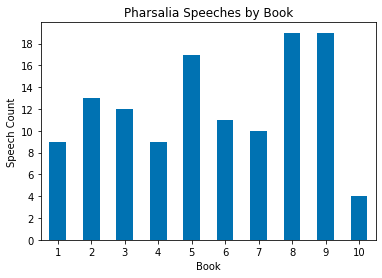

In [19]:
total_speeches = s_table_lucan.groupby('book')['book'].count()
subplot = total_speeches.plot.bar(
    title='Pharsalia Speeches by Book',
    ylabel='Speech Count',
    xlabel='Book',
    rot=0,
    legend=None,
)

# force integer ticks on y-axis
subplot.axes.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/lucan_speech_count_by_book.jpg', dpi=300)

### Female speakers, by addressee gender

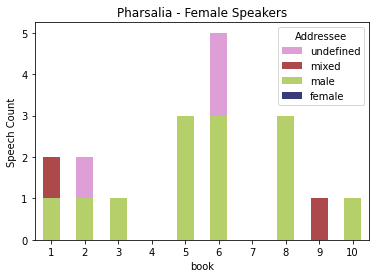

In [20]:
# plot number of speeches per book
subplot = s_table_lucan.pivot_table(
    values='spkr_is_female',
    index='book',
    columns='addr_gender',
    aggfunc='sum',
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Pharsalia - Female Speakers')
ax.set_ylabel('Speech Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/lucan_n_speeches_fem_spkr_by_addr_gender.jpg', dpi=300)

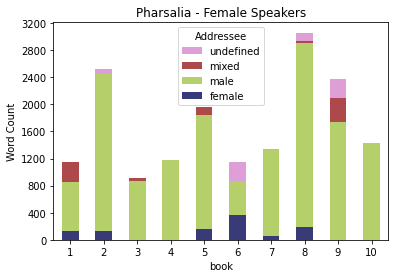

In [21]:
# plot number of words per book
subplot = s_table_lucan.assign(
    fem_word_count=(s_table_lucan.spkr_is_female * s_table_lucan.n_words),
).pivot_table(
    values='n_words',
    index='book',
    columns='addr_gender',
    aggfunc='sum',
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,    
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Pharsalia - Female Speakers')
ax.set_ylabel('Word Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/lucan_n_words_fem_spkr_by_addr_gender.jpg', dpi=300)

### Non-female speakers

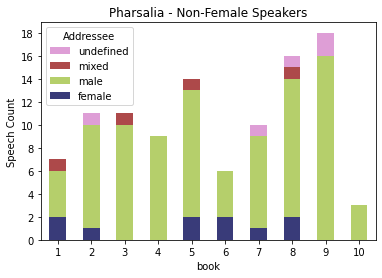

In [22]:
subplot=s_table_lucan.assign(
    spkr_is_male=s_table_lucan.spkr_is_female != True,
).pivot_table(
    values='spkr_is_male',
    index='book', 
    columns='addr_gender', 
    aggfunc='sum'
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,    
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Pharsalia - Non-Female Speakers')
ax.set_ylabel('Speech Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/lucan_non-fem_spkr_by_addr_gender.jpg', dpi=300)

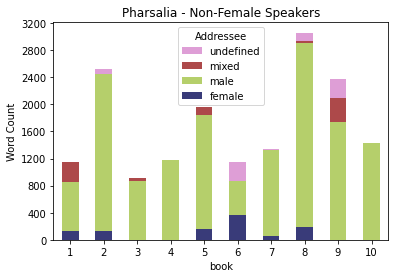

In [23]:
# plot number of words per book
subplot = s_table_lucan.assign(
    male_word_count=((s_table_lucan.spkr_is_female != True) * s_table_lucan.n_words),
).pivot_table(
    values='n_words',
    index='book',
    columns='addr_gender',
    aggfunc='sum',
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,    
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Pharsalia - Non-Female Speakers')
ax.set_ylabel('Word Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/lucan_n_words_non-fem_spkr_by_addr_gender.jpg', dpi=300)

# Same calculations for Silius

In [24]:
urn_silius='urn:cts:latinLit:phi1345.phi001.perseus-lat2'
pickle_silius='silius.pickle'

### Build table of loci versus serial position

In [25]:
# download from perseus
l_table_silius = pd.DataFrame(dict(locus=api.resolver.getReffs(urn_silius, level=2)))

# put book and line numbers into separate cols
l_table_silius[['book', 'line']] = l_table_silius['locus'].str.split('.').apply(pd.Series)

# set create an index so we can look up loci
l_table_silius = l_table_silius.set_index('locus')

In [26]:
l_table_silius

,book,line
locus,,
1.1,1,1
1.2,1,2
1.3,1,3
1.4,1,4
1.5,1,5
...,...,...
17.650,17,650
17.651,17,651
17.652,17,652


### Get the speeches

In [27]:
if os.path.exists(pickle_silius):
    # use cached data if it's there
    print(f'Using cache "{pickle_silius}"...', end='')    

    with open(pickle_silius, 'rb') as f:
        speeches_silius = pickle.load(f)
        
    print(f'loaded {len(speeches_silius)} speeches.')
else:
    # download metadata from DICES
    speeches_silius = api.getSpeeches(work_id=8, progress=True)

    # download the text from Perseus
    pbar = NotebookPBar(max=len(speeches_silius), prefix='retrieving text:')

    for s in speeches_silius:
        if not hasattr(s, 'passage'):
            s.passage = cts.getPassage(s)
        pbar.update()

    # parse with cltk
    pbar = NotebookPBar(max=len(speeches_silius), prefix='parsing:')

    for s in speeches_silius:
        if s.passage.cltk is None:
            s.passage.runCltkPipeline()
        pbar.update()

    # save for later
    with open(pickle_silius, 'wb') as f:
        pickle.dump(speeches_silius, f)

Using cache "silius.pickle"...loaded 318 speeches.


In [28]:
# create a big table
s_table_silius = pd.DataFrame(speech_row(s) for s in speeches_silius)

# cross-reference the loci table to get serial positions w/in work of start/end
s_table_silius['pos_fi'] = s_table_silius['loc_fi'].apply(l_table_silius.index.get_loc)
s_table_silius['pos_la'] = s_table_silius['loc_la'].apply(l_table_silius.index.get_loc)
s_table_silius['n_lines'] = s_table_silius['pos_la'] - s_table_silius['pos_fi'] + 1

s_table_silius.to_csv('silius_export.csv')

### Plot

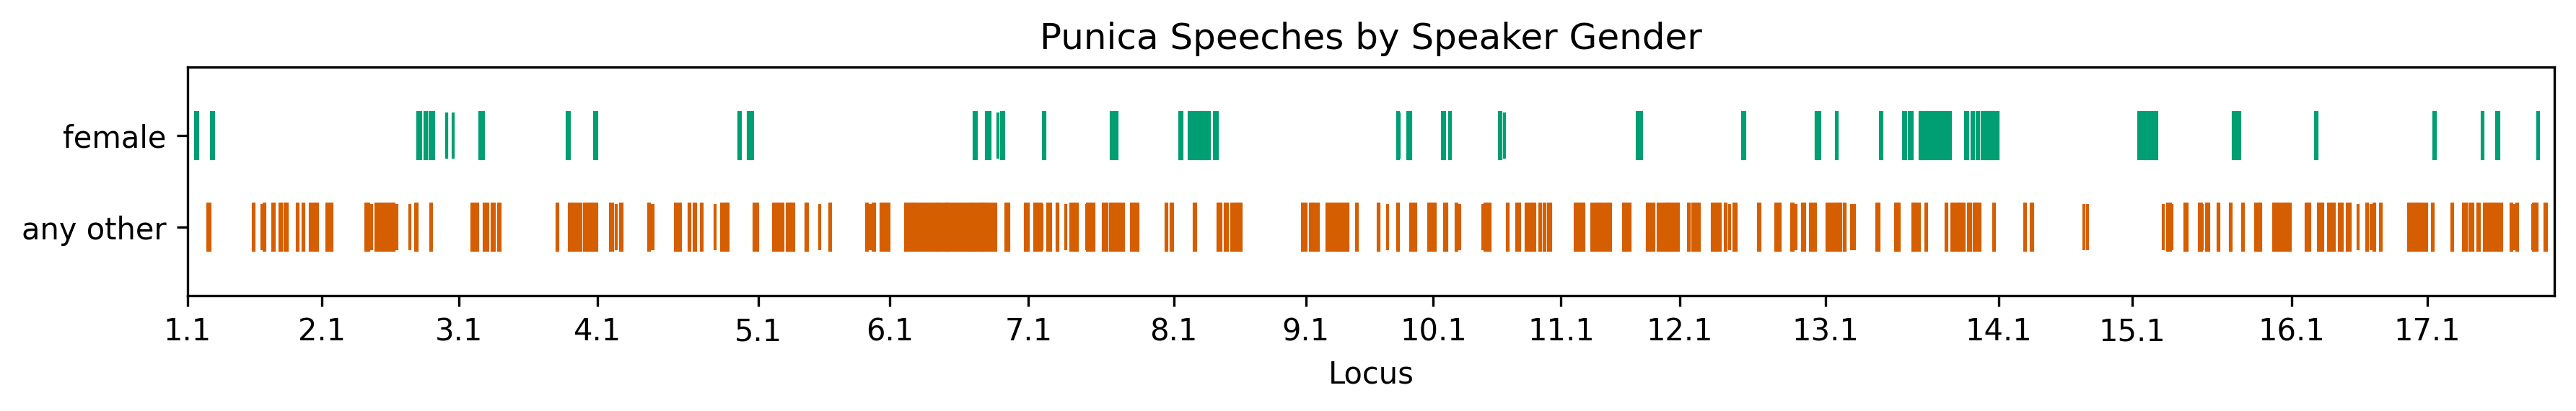

In [29]:
# create an empty plot
fig, ax = plt.subplots(figsize=(12, 2), tight_layout=True, dpi=300)
ax.set_xlim(0, len(l_table_silius))
ax.set_ylim(0, 1)

# vertical locations of the two categories
v_hi = 0.7
v_lo = 0.3

# titles
ax.set_title('Punica Speeches by Speaker Gender')
ax.set_xlabel('Locus')

# mark book divisions
is_div = l_table_silius['line']=='1'
ax.set_xticks(np.flatnonzero(is_div), labels=l_table_silius.index[is_div])
ax.set_yticks([v_lo, v_hi], labels=['any other', 'female'])

# draw speeches as horizontal bars
for row in s_table_silius.itertuples():
    if row.spkr_is_female:
        v = v_hi
        c = 'C1'
    else:
        v = v_lo
        c = 'C2'
    ax.axvspan(row.pos_fi, row.pos_la, v-0.1, v+0.1, color=c)
    
# save as image
fig.savefig('fig/silius_speech_loc_by_gender.jpg')

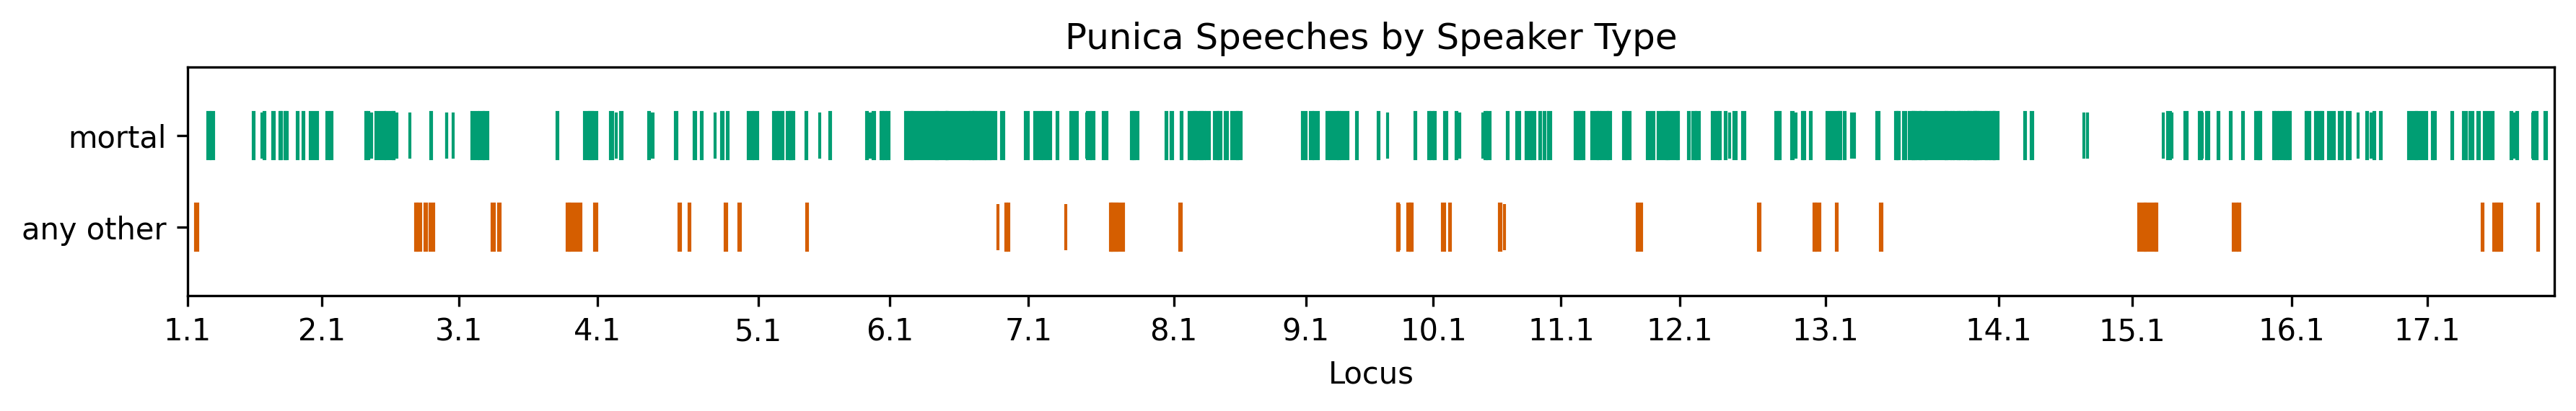

In [30]:
# create an empty plot
fig, ax = plt.subplots(figsize=(12, 2), tight_layout=True, dpi=300)
ax.set_xlim(0, len(l_table_silius))
ax.set_ylim(0, 1)

# vertical locations of the two categories
v_hi = 0.7
v_lo = 0.3

# titles
ax.set_title('Punica Speeches by Speaker Type')
ax.set_xlabel('Locus')

# mark book divisions
is_div = l_table_silius['line']=='1'
ax.set_xticks(np.flatnonzero(is_div), labels=l_table_silius.index[is_div])
ax.set_yticks([v_lo, v_hi], labels=['any other', 'mortal'])

# draw speeches as horizontal bars
for row in s_table_silius.itertuples():
    if row.spkr_is_mortal:
        v = v_hi
        c = 'C1'
    else:
        v = v_lo
        c = 'C2'
    ax.axvspan(row.pos_fi, row.pos_la, v-0.1, v+0.1, color=c)

# save as image
fig.savefig('fig/silius_speech_loc_by_being.jpg')

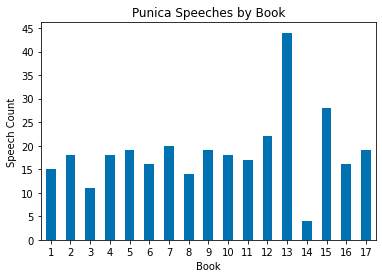

In [31]:
total_speeches = s_table_silius.groupby('book')['book'].count()
subplot = total_speeches.plot.bar(
    title='Punica Speeches by Book',
    ylabel='Speech Count',
    xlabel='Book',
    rot=0,
    legend=None,
)

# force integer ticks on y-axis
subplot.axes.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/silius_speech_count_by_book.jpg', dpi=300)

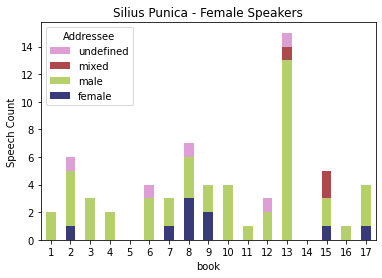

In [32]:
# plot number of speeches per book
subplot = s_table_silius.pivot_table(
    values='spkr_is_female',
    index='book',
    columns='addr_gender',
    aggfunc='sum',
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,    
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Silius Punica - Female Speakers')
ax.set_ylabel('Speech Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/silius_n_speeches_fem_spkr_by_addr_gender.jpg', dpi=300)

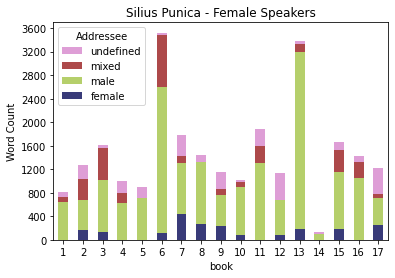

In [33]:
# plot number of words per book
subplot = s_table_silius.assign(
    fem_word_count=(s_table_silius.spkr_is_female * s_table_silius.n_words),
).pivot_table(
    values='n_words',
    index='book',
    columns='addr_gender',
    aggfunc='sum',
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,    
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Silius Punica - Female Speakers')
ax.set_ylabel('Word Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/silius_n_words_fem_spkr_by_addr_gender.jpg', dpi=300)

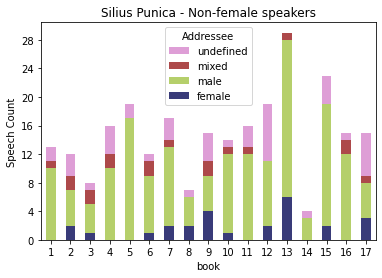

In [34]:
subplot=s_table_silius.assign(
    spkr_is_male=s_table_silius.spkr_is_female != True,
).pivot_table(
    values='spkr_is_male',
    index='book', 
    columns='addr_gender', 
    aggfunc='sum'
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,    
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Silius Punica - Non-female speakers')
ax.set_ylabel('Speech Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/silius_non-fem_spkr_by_addr_gender.jpg', dpi=300)

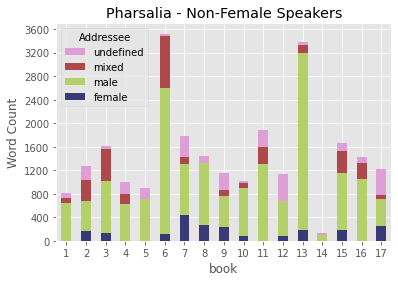

In [35]:
mpl.style.use('ggplot')
# plot number of words per book
subplot = s_table_silius.assign(
    male_word_count=((s_table_silius.spkr_is_female != True) * s_table_silius.n_words),
).pivot_table(
    values='n_words',
    index='book',
    columns='addr_gender',
    aggfunc='sum',
).plot.bar(
    stacked=True,
    rot=0,
    legend='reverse',
    colormap=cmap,    
)

# annotations
ax = subplot.axes
ax.get_legend().set_title('Addressee')
ax.set_title('Pharsalia - Non-Female Speakers')
ax.set_ylabel('Word Count')

# force integer ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# save as image
subplot.get_figure().savefig('fig/silius_n_words_non-fem_spkr_by_addr_gender.jpg', dpi=300)